In [4]:
from importlib.metadata import version
import tensorflow
import summa
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.3.3
1.2.0


# Step1. 데이터 수집하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
96489,Tiger Global-backed startup Cube26 shuts down ...,New Delhi-based mobile technology startup Cube...
58182,Apple to launch cheapest ever 9.7-inch iPad in...,Technology giant Apple is planning to launch c...
5996,PokÃÂ©mon Go creator Niantic to raise $200 mn...,PokÃÂ©mon Go creator Niantic is raising $200 ...
89455,Was he fired? You're kidding: Russian FM on FB...,Russian Foreign Minister Sergey Lavrov on Wedn...
70232,Nobody has ever stood by me the way my kids ha...,Hollywood actress Angelina Jolie has said that...
91233,"Dawood Ibrahim sick but not critical, seen at ...","Dawood Ibrahim, an accused in the 1993 Mumbai ..."
25862,Anand Mahindra offers financial support to spr...,Offering financial support to Indian sprinter ...
45547,World's 500 richest lose more than Netflix's m...,The world's 500 richest people have lost a com...
72176,Kalraj Mishra confirms resigning ahead of Cabi...,"Union Cabinet Minister of Micro, Small and Med..."
35261,Priyanka to make B'wood comeback after 3 yrs w...,Priyanka Chopra will make her Bollywood comeba...


# Step 2. 데이터 전처리하기 (추상적 요약)

In [4]:
# 중복 샘플 유무부터 확인해보겠습니다.
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 중폭 샘플 수가 없었나봅니다

In [6]:
# 결측치가 있는지 확인해보겠습니다
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 결측치가 없으므로 바로 정규화로 넘어가겠습니다.

In [7]:
#정규화 사전 정의하기
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

## 짧은 headlines는 불용어 제거를 하지 않고 text 만 제거해줍니다.

In [10]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

for sentence in data['text']:
    processed_text = preprocess_sentence(sentence, remove_stopwords=True)
    clean_text.append(processed_text)

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
# 전체 headlines 데이터에 대한 전처리
clean_headlines = []

for sentence in data['headlines']:
    processed_headlines = preprocess_sentence(sentence, remove_stopwords=False)
    clean_headlines.append(processed_headlines)

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


## 전처리 이후 생성된 empty값 null로 변경 후 제거하기

In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


여기서도 null값이 발생하지 않았습니다

## text와 headlines의 최소, 최대, 평균 길이 구하고 분포 시각화하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


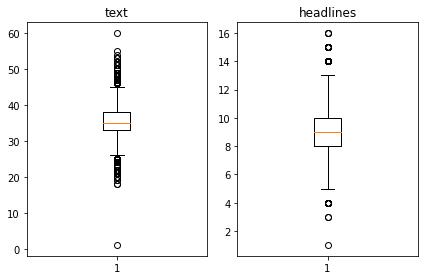

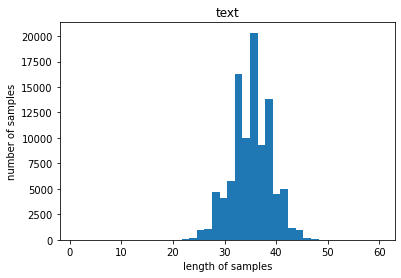

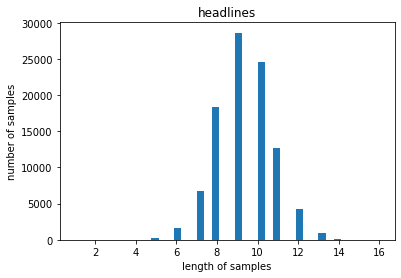

In [13]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
text_max_len = 45
headlines_max_len = 12

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


## 생각보다 분포도 괜찮고, 잘 모여있는 것 같아서 이 정도로만 해도 괜찮을 것 같다

In [17]:
# 임의의 최대 길이 설정
text_max_len = 45  # Text의 최대 길이
headlines_max_len = 12  # headlines의 최대 길이

# Text와 headlines 컬럼의 길이를 기준으로 필터링하는 코드
data = data[data.apply(lambda x: len(x['text'].split()) <= text_max_len and len(x['headlines'].split()) <= headlines_max_len, axis=1)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


### 대략 1500개 정도가 지워짐

## 시작 토큰과 종료 토큰 추가하기

In [18]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


## 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [19]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 훈련데이터와 테스트데이터 분리 (8:2)

In [20]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 데이터 셈플 순서 다시 정의하기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#섞인 데이터 8:2 비율로 분리하기
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val) #테스트 데이터 수 확인해서 몇 개인지 대략 확인

#전체 데이터 양분하기 (: 표시의 위치 주의!)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19374
훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


## 단어 집합 만들기 및 정수 인코딩

In [21]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69093
등장 빈도가 6번 이하인 희귀 단어의 수: 47084
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22009
단어 집합에서 희귀 단어의 비율: 68.14583242875545
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5153414744958678


## 단어 집합에서 빈도가 낮은 데이터를 제외하고, 집합의 크기를 20,000으로 제한 (위 코드의 결과에서 ‘단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기’ 참고)

In [22]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

## 단어 집합 기반하여 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하기

In [23]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1980, 5175, 273, 12126, 232, 80, 3621, 903, 83, 671, 2068, 12127, 1203, 468, 1264, 439, 7503, 2234, 6897, 3878, 11149, 8458, 1264, 355, 98, 371, 3213, 779, 903, 1, 886, 1084, 126, 310, 310, 11150], [36, 2138, 210, 66, 5789, 12, 6898, 4129, 12499, 3031, 376, 17, 3093, 156, 446, 3031, 882, 156, 1482, 8, 3031, 406, 959, 473, 14688, 9962, 2032, 7299, 2591, 2138, 93], [195, 2405, 16577, 2146, 44, 28, 2218, 14, 819, 1270, 2, 4635, 1234, 3032, 3214, 3598, 491, 24, 102, 1337, 9195, 93, 132, 4635, 143, 37, 849, 1622, 9963, 2146, 1]]


## headlines 에도 단어 집합 생성 및 정수화 진행하기

In [24]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [25]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29907
등장 빈도가 5번 이하인 희귀 단어의 수: 19610
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10297
단어 집합에서 희귀 단어의 비율: 65.5699334603939
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.75728827643515


In [26]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 433, 1714, 83, 470, 1325, 1014, 175, 1945, 1622], [1, 69, 232, 3455, 3455, 14, 1715, 551], [1, 3970, 808, 52, 6442, 2288, 6, 237, 349], [1, 6443, 20, 40, 425, 19, 10, 5, 80, 5591], [1, 58, 808, 2651, 6, 226, 293, 3, 5592, 4483]]
target
decoder  [[433, 1714, 83, 470, 1325, 1014, 175, 1945, 1622, 2], [69, 232, 3455, 3455, 14, 1715, 551, 2], [3970, 808, 52, 6442, 2288, 6, 237, 349, 2], [6443, 20, 40, 425, 19, 10, 5, 80, 5591, 2], [58, 808, 2651, 6, 226, 293, 3, 5592, 4483, 2]]


## 패딩 이전에 위의 처리로 생성된 빈 샘플 제거하기

In [27]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


## 패딩하기

In [29]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기

## 모델 설계하기

In [30]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

## 디코더 설계하기

In [31]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

## 디코더 출력층 설계하기

In [32]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 층 만들고 디코더 출력층 수정하기

In [33]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련하기

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
303/303 [==============================] - 37s 98ms/step - loss: 5.6234 - val_loss: 5.2042
Epoch 2/50
303/303 [==============================] - 29s 95ms/step - loss: 5.0388 - val_loss: 4.8244
Epoch 3/50
303/303 [==============================] - 29s 96ms/step - loss: 4.6944 - val_loss: 4.5702
Epoch 4/50
303/303 [==============================] - 30s 98ms/step - loss: 4.4338 - val_loss: 4.3831
Epoch 5/50
303/303 [==============================] - 30s 99ms/step - loss: 4.2251 - val_loss: 4.2390
Epoch 6/50
303/303 [==============================] - 31s 101ms/step - loss: 4.0569 - val_loss: 4.1299
Epoch 7/50
303/303 [==============================] - 32s 104ms/step - loss: 3.9107 - val_loss: 4.0452
Epoch 8/50
303/303 [==============================] - 31s 103ms/step - loss: 3.7850 - val_loss: 3.9760
Epoch 9/50
303/303 [==============================] - 31s 103ms/step - loss: 3.6734 - val_loss: 3.9208
Epoch 10/50
303/303 [==============================] - 31s 104ms/step - loss: 

## 훈련 데이터 결과 시각화

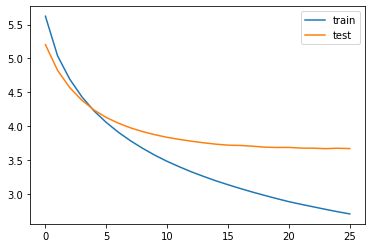

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기 이전 3개의 사전 정의하기

In [36]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

## 인코더와 디코더 모델 분리해서 설계하기

In [37]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

## 어텐션 메커니즘을 사용하는 출력층 설계하기

In [38]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

## 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

In [39]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기

## 결과 확인해보기

In [40]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()

In [41]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    print("예측 헤드라인:", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former england captain alastair cook said would kept mouth shut retirement test cricket england india test series levelled year old batsman said revealed news english team drinking beers otherwise would cried actually 
실제 헤드라인 : would have kept mouth shut on retirement if series was cook
예측 헤드라인:  england will have been in england cricket england test


원문 : apple thursday announced investing billion build new campus austin texas acre campus accommodate initial employees total capacity employees apple also invest billion data centres part five year investment aimed creating jobs us 
실제 헤드라인 : apple to build new billion campus in us texas
예측 헤드라인:  apple to invest mn in us for billion


원문 : cbi court tuesday rejected discharge application filed accused including lk advani uma bharti babri mosque demolition case ruled face criminal conspiracy charges leaders pleaded drop charges saying role demolition babri masjid 
실제 헤드라인 : advani uma bharti to face charges in babri case
예측 헤드라인: 

# Step 5. Summa을 이용해서 추출적 요약해보기

In [5]:
data_2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

## 데이터 일부만 가져오기 (text만 사용)

In [6]:
text = data_2[['text']]
text.head()

text.sample(15)

,text
37978,As many as 600 girls have been reported missin...
68004,'Avatar' director James Cameron has said that ...
58215,Gujarat Chief Minister Vijay Rupani has said C...
40671,A zoo in Australia has shared a video that sho...
8213,German luxury automaker BMW said that it can f...
35388,Police officers said they found animal poop an...
23999,Union Minister Rajyavardhan Rathore said that ...
10873,Team India opener Rohit Sharma on Tuesday brok...
71702,"Kangana Ranaut, in a recent interview with Anu..."
18143,India captain Virat Kohli has said he doesn't ...


## 원문의 0.005% 만 출력하도록 설정하고, 리스트로 출력 결과 받기

In [8]:
from summa.summarizer import summarize

print('Headlines:')
print(summarize(text, ratio=0.005, split=True))

Headlines:


ValueError: Text parameter must be a Unicode object (str)!

## 이렇게 text를 뜯어오면 데이터프레임 객체여서 에러가 발생한다
## 따라서 아래처럼 이를 문자열로 변환해주고 다시 해봤다

In [9]:
# 텍스트 컬럼을 하나의 문자열로 변환
text = ' '.join(data_2['text'].astype(str))

# 텍스트 요약
print('Headlines:')
print(summarize(text, ratio=0.005, split=True))

Headlines:


KeyboardInterrupt: 

In [10]:
# 텍스트 컬럼을 하나의 문자열로 변환
text = ' '.join(data_2['text'].astype(str))

# 텍스트 요약
print('Headlines:')
print(summarize(text, words=50, split=True))

Headlines:


KeyboardInterrupt: 

## 너무 오래걸려서 그루분들께 여쭤보고 상위 100개만 가지고 하면 빨리 된다고 해서 그렇게 해보겠다

In [11]:
# 상위 100개의 텍스트 데이터만 선택
text = ' '.join(data_2['text'].astype(str).head(100))

# 텍스트 요약
print('Headlines:')
print(summarize(text, ratio=0.005, split=True))

Headlines:
['He added, "The time has come for the people of Odisha to put a full stop to their activities...The time has come for us to ask for an explanation from this corrupt government." Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inÃ¢Â\x80Â\x8b Surat, added that the opposition parties have only one agenda which is "Modi".']


## words로 조절해보겠다

In [13]:
# 상위 100개의 텍스트 데이터만 선택
text = ' '.join(data_2['text'].astype(str).head(100))

# 텍스트 요약
print('Headlines:')
print(summarize(text, words=50, split=True))

Headlines:
['He added, "The time has come for the people of Odisha to put a full stop to their activities...The time has come for us to ask for an explanation from this corrupt government." Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inÃ¢Â\x80Â\x8b Surat, added that the opposition parties have only one agenda which is "Modi".']


## 이것도 실제 헤드라인과 비교해봤다

In [19]:
# 실제 헤드라인과 예측 헤드라인을 비교하는 함수 (상위 100개, ratio=0.005 적용)
def compare_summaries(data, ratio=0.5, n=100):
    # 상위 n개의 데이터만 처리
    data = data.head(n)
    
    for i in range(len(data)):
        original_text = data['text'].iloc[i]
        actual_headline = data['headlines'].iloc[i]
        
        # 예측 헤드라인 생성 (텍스트 요약)
        predicted_headline = summarize(original_text, ratio=ratio)

        # 비교 출력
        print(f"원문: {original_text}")
        print(f"실제 헤드라인: {actual_headline}")
        print(f"예측 헤드라인: {predicted_headline if predicted_headline else 'No summary generated'}")
        print("-" * 50)

# 상위 100개 샘플을 대상으로 비교 (ratio=0.005)
compare_summaries(data_2, ratio=0.5, n=100)

원문: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 헤드라인: upGrad learner switches to career in ML & Al with 90% salary hike
예측 헤드라인: upGrad's Online Power Learning has powered 3 lakh+ careers.
--------------------------------------------------
원문: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인: Delhi techie wins free food from Swiggy for one year on CRED
예측 

# 회고
---
* 오늘은 노드와 동일하게 진행하면 크게 문제되는 것은 없었다.
* 하지만, summa를 사용하는 부분에서 text의 크기가 너무 크면 너무 오래걸리는 경향이 있어서 과감하게 상위 100개만 사용하는 등으로 조치했다.
* 시간이 난다면 LSTM 모델이 아니라, 다른 모델들을 적용해서 해보는 것도 재밌을 것 같다.